# Fashion MNIST: A Multi-Class Classification Problem
We will create a multi-class CNN to solve a multi-class classification problem. Fashion MNIST is intended as a drop-in replacement for the classic MNIST dataset - a handwriting digit dataset often used as a "Hello World" dataset for machine learning. Fashion MNIST contains fashion item images, which turns out to be more challenging than MNIST.  

Fashion MNIST contains 60,000 training images and 10,000 test images, 28 x 28 pixels each, with 10 categories. 


## 0. Environment

This can be run both locally and colab. If you are going to run it locally, don't forget to create a virtual environment. Running it on colab, requires the colab extension. Then selecte kernek -> colab and go through the log in process. Colab has all major libraries installed.

## 1. Load the dataset
Keras provides some utility functions to fetch and load some commonly used datasets, including Fashin MNIST. The `load_data()` method directly splits the training and test set. 

Since the class names are not included with the dataset, store them here to use later when plotting the images.

We will explore the format of the dataset, the data type of the input images, also display a few images to have a first impression of the dataset.

In [7]:
from keras.datasets import fashion_mnist # Pip install both keras and tensor flow in the venv
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

n_classes = 10
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Inspect data
print(f" There are {X_train.shape[0]} images which are {X_train.shape[1]} x {X_train.shape[2]} pixels. These are for training.")
print(f" We also have {y_train.shape[0]} labels for each image.")
print(f" An exampe of a label for the first image is {y_train[0]} which corresponds to {class_names[y_train[0]]}")

print(f" There are {X_test.shape[0]} images which are {X_test.shape[1]} x {X_test.shape[2]} pixels. These are for testing.")

# Check that the labels are correct 
print(y_train.dtype, y_train.min(), y_train.max(), y_train.shape)

 There are 60000 images which are 28 x 28 pixels. These are for training.
 We also have 60000 labels for each image.
 An exampe of a label for the first image is 9 which corresponds to Ankle boot
 There are 10000 images which are 28 x 28 pixels. These are for testing.
uint8 0 9 (60000,)


## 2. Prepare the data
Since pixel values in an image are in the same range [0, 255], we don't need to standarize or normalize the input data as what we did for the Indian Diebetes dataset. The only thing we are suppose to do for this dataset is to scale the pixel values down to the [0,1] range by simply dividing them by 255.0 (this also converts them to floats). 

In [8]:
# For each row of data, 
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

# Verify this worked
print(f"After rescaling, an examlpe of training data X-axis pixes are: {X_train[5][0]}")

After rescaling, an examlpe of training data X-axis pixes are: [0.         0.         0.         0.         0.00392157 0.
 0.         0.         0.         0.08627451 0.34509805 0.7372549
 0.6745098  0.5176471  0.49019608 0.5529412  0.78039217 0.56078434
 0.03529412 0.         0.         0.         0.00392157 0.
 0.         0.         0.         0.        ]


## 3. Build the convolutional neural network 
Before, I built a NN for this task. But now I am adding convolutional layers to preserve the spatial layout and learn local patterns. 

This is a simple CNN:

1) Conv-1 layer: 32 filters with size 3 x 3, a stride of 1, and ReLU activation function. Each output feature map must be the same size as the input image size (28 x 28). I am not using larger kernels because they have more parameters and are more prone to overfitting. Since I am using more than 1 Kernel, despite it being small, they will have the same recepting field. I am adding the Relu activation to introduce non linearity. It will turn all negative values to zero. They also help adress vanishing gradients problem . Note: There is just 1 channel as it is grayscale. 
2) Maxpooling-1 layer: filter size 2 x 2, a stride of 2. This one keeps the maximum value in each 2x2 square. The result is effectively a feature map which is reduced by a factor of 2 in H and W than the Conv layer. 
3) Conv-2 layer: 64 filters with size 3 x 3, a stride of 1, no padding and ReLU activation function. Here we are trying to detect larger patterns. from the previos feature map. 
4) A flatten layer to act as the input to the classifier portion of hte CNN
5) Dense layer: 64 neurons with ReLU activation function.
6) The output layer. This is a 10 neuros (same number as classe) with softmax since we already normalised the grayscale to 0-1

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()

# 1st Layer - `Conv2D'
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape= (28,28,1)))

# 2nd layer - Max pooling layer. 
model.add(MaxPooling2D(2,2))

# 3rd layer - 'Conv2D'
model.add(Conv2D(64, (3,3), activation = 'relu'))

# 4th layer - Flatten
model.add(Flatten())

# 5th Layer - Dense
model.add(Dense(64, activation = 'relu'))

# 6th layer - Output
model.add(Dense(10, activation = 'softmax'))

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       495,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,146 (1.97 MB)

 Trainable params: 515,146 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Compile the model
The typical loss function for a multi-class problem is the multi-class cross-entropy loss function. In Keras, there are two options. One is to use the `sparse_categorical_crossentropy` loss with the original sparse labels (i.e., for each image, there is just one actual class index, from 0 to 9 in this case). The other is to use `categorical_crossentropy` loss if the actual output is a one-hot vector (e.g., [0, 0, 1, 0, ...., 0]). In this case, we will need to first convert the current sparse label (i.e., class index) to one-hot vecore labels by using `keras.utils.to_categorical()` method.

In [10]:
# Remember that in y_train, we have labels like y_train[0] =2. So with the sparse categorical cross entropy,
# Keras internally, will take the softmax output, and look at the probability of class 2 and it will compute the cross entropy loss. 

model.compile(
    loss = "sparse_categorical_crossentropy", 
    optimizer = 'adam', # This is not SGD, or Momentum, it increases learning rate when slope is reliable and slows it down when noisy. THIS IS ADAPTIVE LEARNING RATE
    metrics = ['accuracy'] # accuracy = (number of correct predictions) / (total predictions)
)

## 5. Train and validate the model
We use a validation set to moniter your model. We also draw the learning curve on the training and validation sets, to see how your model is learnt and how it generalises to new data, then try to adjust our model and add any regularization techniques accordingly till we are satisfied.

In [11]:
# Firstly, lets create a checkpoint where we store the best model obtained during training.
# We watch validation accurace and save the model when it improves. 
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'fashion_mnist_best.h5', # Where to save the mode
    monitor='val_accuracy', # Which variable to measure
    save_best_only=True, # Only save when the variable improves
    mode='max', # Success is when the metric increases
    verbose=1 # Display messages 
)

callbacks = [checkpoint] # Store each checkpoint in a list

# Now we train the model

print('Starting training...')
# train the model, store the results for plotting
history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # 20% of training used as validation
    epochs=20, # Epoch  = one full pass through the training dataset. `too few = underfitting, too many = overfitting`
    batch_size=128, # Insead of going throuigh 60000 * 0.8 (remmebr train split) images, we group them in groups of 128 so for 1 epoch, the model will update its weights 60000*0.8/128 times
    callbacks=callbacks,
    verbose = "auto"
)

Starting training...
Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7425 - loss: 0.7284
Epoch 1: val_accuracy improved from -inf to 0.87167, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 50s 128ms/step - accuracy: 0.7427 - loss: 0.7278 - val_accuracy: 0.8717 - val_loss: 0.3577
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8775 - loss: 0.3413
Epoch 2: val_accuracy improved from 0.87167 to 0.87667, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 116ms/step - accuracy: 0.8775 - loss: 0.3413 - val_accuracy: 0.8767 - val_loss: 0.3316
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8955 - loss: 0.2922
Epoch 3: val_accuracy improved from 0.87667 to 0.90133, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.8956 - loss: 0.2922 - val_accuracy: 0.9013 - val_loss: 0.2768
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9084 - loss: 0.2501
Epoch 4: val_accuracy improved from 0.90133 to 0.90767, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 45s 120ms/step - accuracy: 0.9084 - loss: 0.2500 - val_accuracy: 0.9077 - val_loss: 0.2589
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9173 - loss: 0.2226
Epoch 5: val_accuracy improved from 0.90767 to 0.91117, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.9174 - loss: 0.2226 - val_accuracy: 0.9112 - val_loss: 0.2473
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9254 - loss: 0.1997
Epoch 6: val_accuracy improved from 0.91117 to 0.91600, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 85s 125ms/step - accuracy: 0.9254 - loss: 0.1997 - val_accuracy: 0.9160 - val_loss: 0.2314
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9339 - loss: 0.1826
Epoch 7: val_accuracy did not improve from 0.91600
375/375 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.9339 - loss: 0.1826 - val_accuracy: 0.9120 - val_loss: 0.2437
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9388 - loss: 0.1667
Epoch 8: val_accuracy improved from 0.91600 to 0.91875, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 117ms/step - accuracy: 0.9388 - loss: 0.1667 - val_accuracy: 0.9187 - val_loss: 0.2231
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9460 - loss: 0.1502
Epoch 9: val_accuracy improved from 0.91875 to 0.91942, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 114ms/step - accuracy: 0.9460 - loss: 0.1502 - val_accuracy: 0.9194 - val_loss: 0.2281
Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9533 - loss: 0.1312
Epoch 10: val_accuracy did not improve from 0.91942
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.9533 - loss: 0.1312 - val_accuracy: 0.9099 - val_loss: 0.2596
Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9533 - loss: 0.1267
Epoch 11: val_accuracy did not improve from 0.91942
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.9533 - loss: 0.1267 - val_accuracy: 0.9170 - val_loss: 0.2438
Epoch 12/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9630 - loss: 0.1036
Epoch 12: val_accuracy improved from 0.91942 to 0.92492, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.9630 - loss: 0.1036 - val_accuracy: 0.9249 - val_loss: 0.2316
Epoch 13/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9675 - loss: 0.0930
Epoch 13: val_accuracy did not improve from 0.92492
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 114ms/step - accuracy: 0.9675 - loss: 0.0930 - val_accuracy: 0.9138 - val_loss: 0.2577
Epoch 14/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9692 - loss: 0.0869
Epoch 14: val_accuracy did not improve from 0.92492
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 115ms/step - accuracy: 0.9692 - loss: 0.0869 - val_accuracy: 0.9205 - val_loss: 0.2533
Epoch 15/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9723 - loss: 0.0750
Epoch 15: val_accuracy did not improve from 0.92492
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.9723 - loss: 0.0750 - val_accuracy: 0.9174 - val_loss: 0.2675
Epoch 16/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9778 - loss: 0.0627
Epoch 16

375/375 ━━━━━━━━━━━━━━━━━━━━ 44s 116ms/step - accuracy: 0.9863 - loss: 0.0407 - val_accuracy: 0.9255 - val_loss: 0.2976
Epoch 20/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9884 - loss: 0.0345
Epoch 20: val_accuracy did not improve from 0.92550
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 115ms/step - accuracy: 0.9884 - loss: 0.0345 - val_accuracy: 0.9228 - val_loss: 0.2982


## 6. Create the accuracy plots

Accuracy plots show how often the model predicts the correct class over time. The training accuracy indicates how well the model fits the training data, while the validation accuracy shows how well the model generalises to unseen data. Comparing the two helps identify underfitting (both accuracies low) or overfitting (training accuracy high but validation accuracy significantly lower).

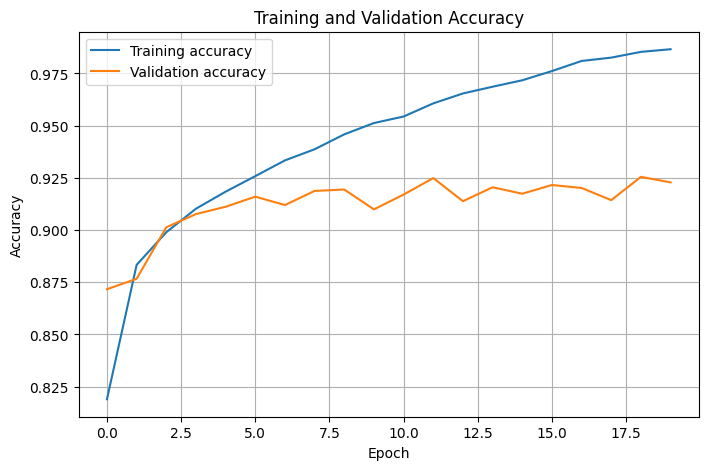

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 5))

plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()

## 7. Create the loss plots

Loss plots show how wrong the model’s predictions are and how confident those predictions are. Training loss reflects how well the model is learning the training data, while validation loss indicates how stable and reliable the model is on unseen data. Diverging loss curves—where training loss decreases but validation loss increases—are a strong sign of overfitting.

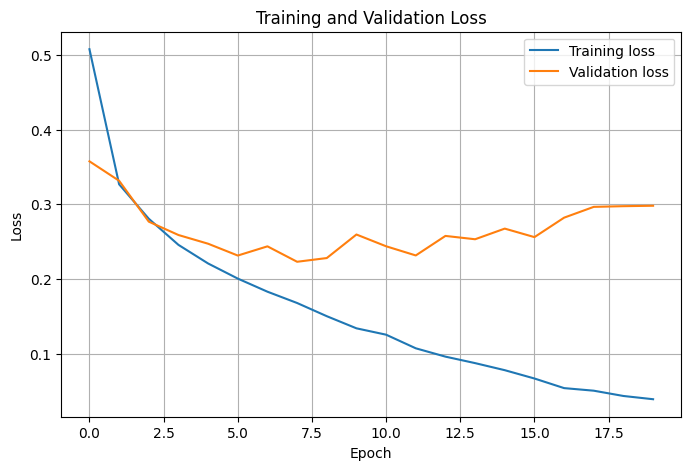

In [13]:
plt.figure(figsize=(8, 5))

plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

plt.show()

## 8. Evaluate the model
First evaluate our model on the test set to report the accuracy on the test set. Then use the `model`'s `predict()` method to make predictions on new instances. Display a few images and compare their predicting classes with their actual classes.

In [14]:
# Evalute the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on new data
y_pred_prob = model.predict(X_test)

Test accuracy: 0.9203
Test loss: 0.3299
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
